---
title: "Predicting swarm behaviour"
author: "Temi"
description: "..."
date: "Mon 18 July 2022"
format:
    html:
        code-fold: true
categories: [pytorch, deep learning]
---

# Introduction

To practice my deep learning chops/model-writing skills, I pick a toy dataset. Here I aim to predict swarm behaviour. 

In [5]:
import torch
import numpy as np, os, sys, requests, pandas as pd, zipfile as zf
import matplotlib.pyplot as plt

print(f'Kernel used is: {os.path.basename(sys.executable.replace("/bin/python",""))}')

Kernel used is: dl-tools


In [6]:
print(f'Pytorch version is {torch.__version__}')

Pytorch version is 2.0.1+cu117


In [7]:
torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.device_count(), torch.cuda.get_device_name(0)

(True, 0, 1, 'Quadro P1000')

In [8]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Quadro P1000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [9]:
# os.chdir("/home/temi/Files/learning_stuff/pytorch_implementations/swarm behaviour/scripts")
# os.getcwd()

In [10]:
data_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00524/Swarm%20Behavior%20Data.zip'

In [13]:
data_dir = '/home/temi/Files/learning_stuff/pytorch_implementations/swarm behaviour'

In [14]:
if not 'data' in os.listdir(data_dir):
    os.mkdir('/home/temi/Projects/swarm_behaviour/data/')
else:
    print('data directory already exists.')

data directory already exists.


In [15]:
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

In [16]:
data_path = os.path.join(data_dir, 'data', 'swarm_behaviour.zip')

if not 'swarm_behaviour.zip' in os.listdir(os.path.join(data_dir, 'data')):
    print('Downloading...')
    download_url(data_link, )
    print('Done.')
else:
    print('File already present.')

File already present.


In [17]:
with zf.ZipFile(data_path, 'r') as obj:
    name_of_files = obj.namelist()[1:]

name_of_files

['Swarm Behavior Data/Aligned.csv',
 'Swarm Behavior Data/Flocking.csv',
 'Swarm Behavior Data/Grouped.csv']

In [18]:
# read in each file into a dictionary
keys = ['aligned', 'flocking', 'grouped']
swarm_data = dict()
for i, file_name in enumerate(name_of_files):
    zipfile = zf.ZipFile(data_path)
    swarm_data[keys[i]] = pd.read_csv(zipfile.open(file_name))
    zipfile.close()

/tmp/ipykernel_184041/1264924189.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  swarm_data[keys[i]] = pd.read_csv(zipfile.open(file_name))


In [19]:
swarm_data['aligned'].iloc[0:5,:]

,x1,y1,xVel1,yVel1,xA1,yA1,xS1,yS1,xC1,yC1,...,yVel200,xA200,yA200,xS200,yS200,xC200,yC200,nAC200,nS200,Class
0,-1414.14,-535.22,-17.88,-7.23,0.00,0.0,0.00,0.00,0.00,0.00,...,-16.85,0.0,0.00,0.0,0.0,0.00,0.00,29,0,0
1,-1412.93,597.54,-13.55,-5.48,0.00,0.0,0.00,0.00,0.00,0.00,...,-12.09,0.0,0.00,0.0,0.0,0.00,0.00,44,0,0
2,-1407.38,70.72,-14.37,-5.81,0.00,0.0,0.00,0.00,0.00,0.00,...,-16.20,0.0,0.00,0.0,0.0,0.00,0.00,40,0,0
3,-1407.00,-759.80,-7.59,-1.27,-0.98,-0.2,0.00,0.00,0.91,0.41,...,2.99,-1.0,-0.07,0.0,0.0,-0.52,0.86,3,0,1
4,-1406.36,698.39,-16.54,-6.95,-1.00,0.0,-944.07,-396.62,0.00,0.00,...,-12.61,0.0,-1.00,0.0,0.0,0.00,0.00,13,0,0


In [20]:
swarm_data['flocking'].iloc[0:5,0:]

,x1,y1,xVel1,yVel1,xA1,yA1,xS1,yS1,xC1,yC1,...,yVel200,xA200,yA200,xS200,yS200,xC200,yC200,nAC200,nS200,Class
0,-1414.14,-535.22,-17.88,-7.23,0.00,0.0,0.00,0.00,0.00,0.00,...,-16.85,0.0,0.00,0.0,0.0,0.00,0.00,29,0,0
1,-1412.93,597.54,-13.55,-5.48,0.00,0.0,0.00,0.00,0.00,0.00,...,-12.09,0.0,0.00,0.0,0.0,0.00,0.00,44,0,0
2,-1407.38,70.72,-14.37,-5.81,0.00,0.0,0.00,0.00,0.00,0.00,...,-16.20,0.0,0.00,0.0,0.0,0.00,0.00,40,0,0
3,-1407.0,-759.80,-7.59,-1.27,-0.98,-0.2,0.00,0.00,0.91,0.41,...,2.99,-1.0,-0.07,0.0,0.0,-0.52,0.86,3,0,1
4,-1406.36,698.39,-16.54,-6.95,-1.00,0.0,-944.07,-396.62,0.00,0.00,...,-12.61,0.0,-1.00,0.0,0.0,0.00,0.00,13,0,0


In [16]:
swarm_data['grouped'].iloc[0:5,:]

,x1,y1,xVel1,yVel1,xA1,yA1,xS1,yS1,xC1,yC1,...,yVel200,xA200,yA200,xS200,yS200,xC200,yC200,nAC200,nS200,Class
0,-1414.14,-535.22,-17.88,-7.23,0.00,0.0,0.00,0.00,0.00,0.00,...,-16.85,0.0,0.00,0.0,0.0,0.00,0.00,29,0,0
1,-1412.93,597.54,-13.55,-5.48,0.00,0.0,0.00,0.00,0.00,0.00,...,-12.09,0.0,0.00,0.0,0.0,0.00,0.00,44,0,0
2,-1407.38,70.72,-14.37,-5.81,0.00,0.0,0.00,0.00,0.00,0.00,...,-16.20,0.0,0.00,0.0,0.0,0.00,0.00,40,0,0
3,-1407.00,-759.80,-7.59,-1.27,-0.98,-0.2,0.00,0.00,0.91,0.41,...,2.99,-1.0,-0.07,0.0,0.0,-0.52,0.86,3,0,1
4,-1406.36,698.39,-16.54,-6.95,-1.00,0.0,-944.07,-396.62,0.00,0.00,...,-12.61,0.0,-1.00,0.0,0.0,0.00,0.00,13,0,0


In [21]:

def split_into_train_val_test(df, tr_frac=0.5, rem_frac=0.5, seed=1, where_target='last',
                             return_what='dict'):
    
    # shuffle the dataframe
    df = df.sample(frac=1, random_state=seed)

    if where_target=='last':
        df_preds = df.iloc[:, :-1]
        df_targets = df.iloc[:, -1]

    # split into training and testing
    # 0.7, 0.3
    split_one = int(df_preds.shape[0] * tr_frac)

    df_preds_train = df_preds[:split_one]
    df_targets_train = df_targets[:split_one]
    remaining_preds, remaining_targets = df_preds[split_one:], df_targets[split_one:]

    split_two = int(remaining_preds.shape[0]*rem_frac)
    df_preds_val = remaining_preds[:split_two]
    df_preds_test = remaining_preds[split_two:]

    df_targets_val = remaining_targets[:split_two]
    df_targets_test = remaining_targets[split_two:]

    print(df_preds_train.shape, df_targets_train.shape)
    print(df_preds_val.shape, df_targets_val.shape)
    print(df_preds_test.shape, df_targets_test.shape)
    
    if return_what=='dict':
        return  {'train': (df_preds_train.to_numpy(), df_targets_train.to_numpy()), 
                 'validate': (df_preds_val.to_numpy(), df_targets_val.to_numpy()),
                 'test': (df_preds_test.to_numpy(), df_targets_test.to_numpy())}
    elif return_what=='tuple':
        return ((df_preds_train.to_numpy(), df_targets_train.to_numpy()), 
                (df_preds_val.to_numpy(), df_targets_val.to_numpy()), 
                (df_preds_test.to_numpy(), df_targets_test.to_numpy()))

Normalize the data

In [22]:
# standardizing the data
mean_ = swarm_data['aligned'].iloc[:, :-1].mean(axis=0)
std_ = swarm_data['aligned'].iloc[:, :-1].std(axis=0)

swarm_data['aligned'].iloc[:, :-1] = (swarm_data['aligned'].iloc[:, :-1] - mean_)/std_

Split the data

In [23]:
data_split = split_into_train_val_test(df=swarm_data['aligned'], return_what='tuple')
X_train, y_train = data_split[0]
X_test, y_test = data_split[1]
X_valid, y_valid = data_split[2]

# 
X_train = torch.tensor(X_train, dtype=torch.float64).to(device)
y_train = torch.tensor(y_train).type(torch.LongTensor).to(device)

X_test = torch.tensor(X_test, dtype=torch.float64).to(device)
y_test = torch.tensor(y_test).type(torch.LongTensor).to(device)

(12008, 2400) (12008,)
(6004, 2400) (6004,)
(6004, 2400) (6004,)


In [24]:
X_train.is_cuda

True

# Defining the model

In [25]:
class SwarmNN(torch.nn.Module):
    
    '''
    
    '''
    
    def __init__(self, in_dim, out_dim, hidden_dims=[], use_bias=True):
        '''
        Constructs a multilayer perceptron
        '''
        
        super(SwarmNN, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        # assuming we don't have any hidden layer, this will just implement a linear model
        if len(hidden_dims) == 0:
            layers = [torch.nn.Linear(in_dim, out_dim, bias=use_bias)]
        else:
            layers = [torch.nn.Linear(in_dim, hidden_dims[0], bias=use_bias), torch.nn.ReLU()]
            
            for i, hidden_dim in enumerate(hidden_dims[:-1]):
                layers += [torch.nn.Linear(hidden_dim, hidden_dims[i+1], bias=use_bias), torch.nn.ReLU()]
            layers += [torch.nn.Linear(hidden_dims[-1], out_dim, bias=use_bias)]
            
        self.main = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        
        hidden_output = self.main(x)
        output = torch.nn.functional.softmax(hidden_output, dim=1)
        #output = output.argmax(dim=1)
        
        return output

In [26]:
model = SwarmNN(in_dim=X_train.shape[1], out_dim=2, hidden_dims=[500, 100]).to(device)
model

SwarmNN(
  (main): Sequential(
    (0): Linear(in_features=2400, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [27]:
for param in model.parameters():
    print(param.shape)

torch.Size([500, 2400])
torch.Size([500])
torch.Size([100, 500])
torch.Size([100])
torch.Size([2, 100])
torch.Size([2])


## Data loaders

In [28]:
# trainloader = torch.utils.data.DataLoader((X_train, y_train), batch_size=32, shuffle=True)
# testloader = torch.utils.data.DataLoader((X_test, y_test), batch_size=32, shuffle=False)

In [29]:
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fxn = torch.nn.CrossEntropyLoss()

In [31]:
num_epochs = 500

loss_tally = []
acc_tally = []
metrics = {}

# for the test set
test_loss = []
test_acc = []

for epoch in range(0, num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train.float()).to(device)
    loss = loss_fxn(predictions, y_train)
    acc = torch.mean(1.0 * (predictions.argmax(dim=1) == y_train))
    loss.backward()
    optimizer.step()

    #running_loss += loss.item()
    #loss_tally.append(running_loss)
    loss_tally.append(loss.cpu().item())
    acc_tally.append(acc.cpu().item())
    
    # on the test set
    with torch.no_grad():
        model.eval()
        test_pred = model(X_test.float())
        test_l = loss_fxn(test_pred, y_test).item()
        
        #print(f'Test loss {epoch}: {test_l}')
        test_loss.append(test_l)
        test_acc.append(torch.mean(1.0 * (test_pred.argmax(dim=1) == y_test)).item())
        

metrics['train_loss'] = loss_tally
metrics['train_accuracy'] = acc_tally
metrics['test_loss'] = test_loss
metrics['test_accuracy'] = test_acc

In [36]:
test_loss[-20:], loss_tally[-20:]

([0.32089731097221375,
  0.3208724856376648,
  0.3208479583263397,
  0.32082340121269226,
  0.3207990229129791,
  0.3207748234272003,
  0.32075071334838867,
  0.3207266926765442,
  0.32070282101631165,
  0.32067909836769104,
  0.3206555247306824,
  0.3206319808959961,
  0.32060864567756653,
  0.3205854296684265,
  0.32056230306625366,
  0.320539265871048,
  0.3205163776874542,
  0.32049357891082764,
  0.32047098875045776,
  0.32044848799705505],
 [0.3208702802658081,
  0.32084545493125916,
  0.3208208382129669,
  0.32079631090164185,
  0.3207719027996063,
  0.3207475543022156,
  0.3207234740257263,
  0.320699542760849,
  0.3206755518913269,
  0.3206517994403839,
  0.32062822580337524,
  0.3206046521663666,
  0.320581316947937,
  0.32055801153182983,
  0.3205348551273346,
  0.3205118775367737,
  0.32048892974853516,
  0.32046613097190857,
  0.3204434812068939,
  0.32042089104652405])

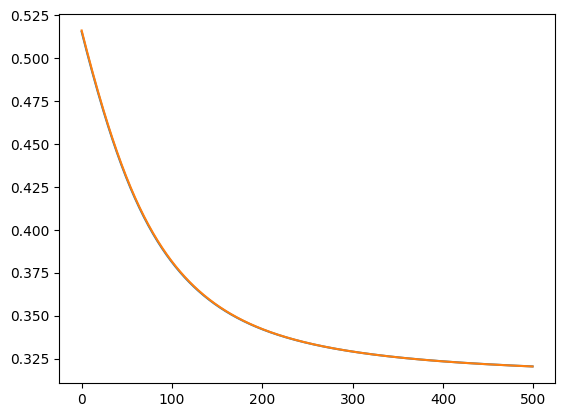

In [42]:
plt.plot(metrics['test_loss'])
plt.plot(metrics['train_loss'])

In [49]:
def plot_my_training(metrics):

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].plot(range(len(metrics['train_loss'])), metrics['train_loss'],
            alpha=0.8, label='Train')
    ax[0].plot(range(len(metrics['test_loss'])), metrics['test_loss'], label='Test')
    ax[0].set_xlabel('Iteration/Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(range(len(metrics['train_accuracy'])), metrics['train_accuracy'],
            alpha=0.8, label='Train')
    ax[1].plot(range(len(metrics['test_accuracy'])), metrics['test_accuracy'], label='Test')
    ax[1].set_xlabel('Iteration/Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

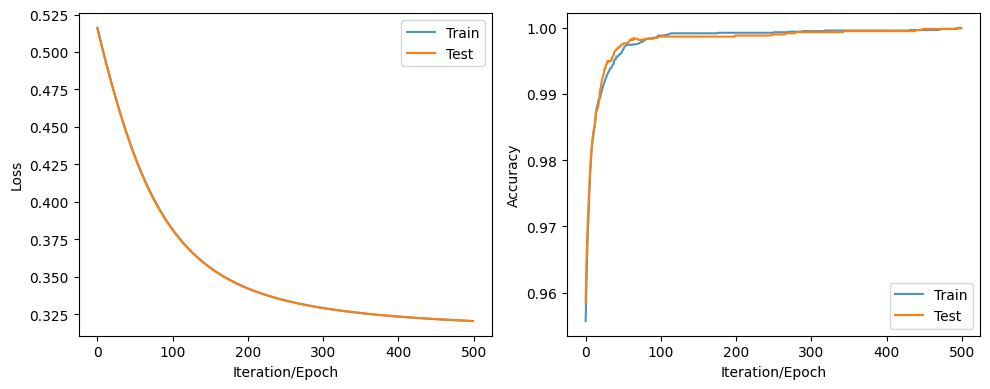

In [50]:
plot_my_training(metrics)